In [34]:
# Libraries and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split
import math  
import seaborn as sns
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from skopt import forest_minimize
import grenade_functions as gf

pd.set_option("display.max_rows", None, "display.max_columns", None)
rcParams['figure.figsize'] = 8, 8
plt.style.use('bmh')
plt.style.use('dark_background')

In [41]:
def get_data_balance(df, method):
    if method == 'oversampling':
        sub_df1 = df.loc[(df.LABEL==False)]
        sub_df2 = df.loc[(df.LABEL==False)]
        sub_df3 = df.loc[(df.LABEL==False)]

        sub_df1.loc[:,'throw_tick'] = sub_df1.loc[:,'throw_tick'] + 50
        sub_df1.loc[:,'detonation_tick'] = sub_df1.loc[:,'detonation_tick'] + 50
        sub_df1.loc[:,'throw_from_raw_x'] = sub_df1.loc[:,'throw_from_raw_x'] - 20
        sub_df1.loc[:,'throw_from_raw_y'] = sub_df1.loc[:,'throw_from_raw_y'] - 20  

        sub_df2.loc[:,'throw_tick'] = sub_df2.loc[:,'throw_tick'] - 50
        sub_df2.loc[:,'detonation_tick'] = sub_df2.loc[:,'detonation_tick'] - 50
        sub_df2.loc[:,'throw_from_raw_x'] = sub_df2.loc[:,'throw_from_raw_x'] + 20
        sub_df2.loc[:,'throw_from_raw_y'] = sub_df2.loc[:,'throw_from_raw_y'] + 20  

        sub_df3.loc[:,'throw_from_raw_x'] = sub_df3.loc[:,'throw_from_raw_x'] - 20
        sub_df3.loc[:,'throw_from_raw_y'] = sub_df3.loc[:,'throw_from_raw_y'] - 20  
        sub_df3.loc[:,'detonation_raw_z'] = sub_df3.loc[:,'detonation_raw_z'] + 25
        sub_df3.loc[:,'detonation_raw_y'] = sub_df3.loc[:,'detonation_raw_y'] + 25 
        sub_df3 = sub_df3[0:-30]

        df = pd.concat([df,sub_df1,sub_df2,sub_df3])
        return df

    if method == 'undersampling':
        false_df = df.loc[df["LABEL"]==False]
        true_df = df.loc[df["LABEL"]==True]
        df_true1, df_true2 = train_test_split(true_df, test_size=0.26, random_state=1)
        df = pd.concat([false_df,df_true2])

        return df
    
def get_map_areas(df,nr_of_areas):
    if df.map_name[0] == 'de_mirage':
        # Min and Max coordinates for de_mirage
        X = [-3217,1912] 
        Y = [-3401,1682]
    if df.map_name[0] == 'de_inferno':
        # Min and Max coordinates for de_inferno
        X = [-1960,2797] 
        Y = [-1062,3800]
    # Size of map
    size_X = X[1] - X[0] 
    size_Y = Y[1] - Y[0]
    # New columns for new features
    df.insert(len(df.columns), "Thrown_X_Area",'') 
    df.insert(len(df.columns), "Thrown_Y_Area",'') 
    df.insert(len(df.columns), "Detonated_X_Area",'') 
    df.insert(len(df.columns), "Detonated_Y_Area",'') 
    # Divide map into areas
    divider_X = size_X/nr_of_areas
    divider_Y = size_Y/nr_of_areas
    for i in range(1,nr_of_areas+1):
        df.loc[(df.throw_from_raw_x>=(i*divider_X-divider_X + X[0])) & 
               (df.throw_from_raw_x<=(i*divider_X + X[0])),'Thrown_X_Area'] = i
        df.loc[(df.detonation_raw_x>=(i*divider_X-divider_X + X[0])) &
               (df.detonation_raw_x<=(i*divider_X + X[0])),'Detonated_X_Area'] = i
        df.loc[(df.detonation_raw_y>=(i*divider_Y-divider_Y + Y[0])) &
               (df.detonation_raw_y<=(i*divider_Y + Y[0])),'Detonated_Y_Area'] = i
        df.loc[(df.throw_from_raw_y>=(i*divider_Y-divider_Y + Y[0])) &
               (df.throw_from_raw_y<=(i*divider_Y + Y[0])),'Thrown_Y_Area'] = i

    return df

def get_dummies_cols(df):
    # get dummies
    df = pd.concat([df,pd.get_dummies(df['team'],prefix="team")],axis=1)
    df = pd.concat([df,pd.get_dummies(df['TYPE'],prefix="TYPE")],axis=1)
    df = pd.concat([df,pd.get_dummies(df['map_name'],prefix="map_name")],axis=1) 
    df = pd.concat([df,pd.get_dummies(df['Thrown_X_Area'],prefix="Thrown_X_Area")],axis=1)
    df = pd.concat([df,pd.get_dummies(df['Thrown_Y_Area'],prefix="Thrown_Y_Area")],axis=1)
    df = pd.concat([df,pd.get_dummies(df['Detonated_X_Area'],prefix="Detonated_X_Area")],axis=1)
    df = pd.concat([df,pd.get_dummies(df['Detonated_Y_Area'],prefix="Detonated_Y_Area")],axis=1)

    df = df.drop(columns=['Unnamed: 0','demo_id','demo_round_id','weapon_fire_id','map_name','TYPE','team','Thrown_X_Area','Thrown_Y_Area','Detonated_X_Area','Detonated_Y_Area'])

    return df

def check_data_balance(df):
    # Check data balance
    plt.style.use('seaborn-poster')

    data = {'Good Thrown':sum(df.LABEL.astype(int)), 'Bad Thrown':(len(df)-sum(df.LABEL.astype(int)))} 
    courses = list(data.keys()) 
    values = list(data.values()) 

    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(courses, values, color ='red', width = 0.4) 

    plt.xlabel("Good vs Bad Throwns") 
    plt.ylabel("Number of Thrown Granades") 
    plt.show() 
    
def get_deviation_features(df):
    # Select columns to group by
    features_to_groupby = [
        'map_name',
        'team',
        'TYPE',
        '10_sec_frame']
    # Select columns to calculate mean value of them
    columns_to_get_mean = ['throw_from_raw_x','detonation_raw_x','throw_from_raw_y','detonation_raw_y']
    # Calculate mean values
    grouped_df = df.groupby(features_to_groupby)
    mean_df = grouped_df['throw_from_raw_x','detonation_raw_x','throw_from_raw_y','detonation_raw_y'].mean()
    mean_df = mean_df.reset_index()
    mean_df.columns = [*mean_df.columns[:-4], 'mean_throw_from_raw_x','mean_detonation_raw_x',
                       'mean_throw_from_raw_y','mean_detonation_raw_y']
    df = df.merge(mean_df, how = 'inner', on = features_to_groupby)
    # Calculate deviation values
    df['throw_dev_x'] = df['throw_from_raw_x'] - df['mean_throw_from_raw_x']
    df['throw_dev_y'] = df['throw_from_raw_y'] - df['mean_throw_from_raw_y']
    df['detonation_dev_x'] = df['detonation_raw_x'] - df['mean_detonation_raw_x']
    df['detonation_dev_y'] = df['detonation_raw_y'] - df['mean_detonation_raw_y']
    df = df.reset_index()
    return df


def get_deviation_features(df):
    # Select columns to group by
    features_to_groupby = [
        'map_name',
        'team',
        'TYPE',
        '10_sec_frame']
    # Select columns to calculate mean value of them
    columns_to_get_mean = ['throw_from_raw_x','detonation_raw_x','throw_from_raw_y','detonation_raw_y']
    # Calculate mean values
    grouped_df = df.groupby(features_to_groupby)
    mean_df = grouped_df['throw_from_raw_x','detonation_raw_x','throw_from_raw_y','detonation_raw_y'].mean()
    mean_df = mean_df.reset_index()
    mean_df.columns = [*mean_df.columns[:-4], 'mean_throw_from_raw_x','mean_detonation_raw_x','mean_throw_from_raw_y','mean_detonation_raw_y']
    df = df.merge(mean_df, how = 'inner', on = features_to_groupby)
    df.drop_duplicates(keep=False,inplace=True) 
    df['throw_dev_x'] = df['throw_from_raw_x'] - df['mean_throw_from_raw_x']
    df['throw_dev_y'] = df['throw_from_raw_y'] - df['mean_throw_from_raw_y']
    df['detonation_dev_x'] = df['detonation_raw_x'] - df['mean_detonation_raw_x']
    df['detonation_dev_y'] = df['detonation_raw_y'] - df['mean_detonation_raw_y']
    df = df.reset_index()
    return df

def get_plot_of_devaition(df,sentiment):
    df = df.loc[(df.LABEL==False), ['throw_dev_x','throw_dev_y','detonation_dev_x','detonation_dev_y']]
    sent = 'Badly'
    
    if sentiment:
        sent = "Well"
        df = df.loc[(df.LABEL==True), ['throw_dev_x','throw_dev_y','detonation_dev_x','detonation_dev_y']]
        
    plt.scatter(df.detonation_dev_x,df.detonation_dev_y,zorder=4,alpha=0.6, label='Grenades Detonated')
    plt.scatter(df.throw_dev_x,df.throw_dev_y,zorder=4,alpha=0.6, label='Grenades Thrown')
    plt.legend()
    plt.title("Relative Deviation of " +sent+ " Thrown Grenades")
    plt.ylabel('Y-cords')
    plt.xlabel('X-cords')
    plt.show()    
    
def get_distance_features(df):
    df['throw_x_distance'] = df['throw_from_raw_x'] - df['detonation_raw_x'] 
    df['throw_z_distance'] = df['throw_from_raw_z'] - df['detonation_raw_z'] 
    df['throw_y_distance'] = df['throw_from_raw_y'] - df['detonation_raw_y'] 
    df['total_distance'] = abs(df['throw_y_distance']) +  abs(df['throw_z_distance']) +abs(df['throw_x_distance'])
    return df 


## Load Data

In [42]:
# Load Data
df_mirage = pd.read_csv('H:/cs/train-grenades-de_mirage.csv')
df_inferno = pd.read_csv('H:/cs/train-grenades-de_inferno.csv')

#df_mirage = pd.read_csv('H:/cs/train-grenades-de_mirage.csv')
#df_inferno = pd.read_csv('H:/cs/train-grenades-de_inferno.csv')

# get map area feature
df_mirage = get_map_areas(df_mirage,4)
df_inferno = get_map_areas(df_inferno,4)

df_over = pd.concat([df_mirage,df_inferno])
df_under = pd.concat([df_mirage,df_inferno])

## Prepare Data

In [43]:
# get data balance
df_over = get_data_balance(df_over,'oversampling')
df_under = get_data_balance(df_under,'undersampling')

# get feature - 10second frames of game
df_over['10_sec_frame'] = (df_over['throw_tick']/128/10).astype(int)
df_under['10_sec_frame'] = (df_under['throw_tick']/128/10).astype(int)

# get deviation features
df_over = get_deviation_features(df_over)
df_under = get_deviation_features(df_under)

# get dummies
df_over = get_dummies_cols(df_over)
df_under = get_dummies_cols(df_under)

df_over = get_distance_features(df_over)
df_under = get_distance_features(df_under)


C:\Users\Adrian\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Adrian\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:131: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [5]:
df_under = df_under.drop(columns=['index','mean_throw_from_raw_x','mean_detonation_raw_x','mean_throw_from_raw_y','mean_detonation_raw_y'])
df_over = df_over.drop(columns=['index','mean_throw_from_raw_x','mean_detonation_raw_x','mean_throw_from_raw_y','mean_detonation_raw_y'])
df_under

,round_start_tick,detonation_raw_x,detonation_raw_y,detonation_raw_z,throw_from_raw_x,throw_from_raw_y,throw_from_raw_z,throw_tick,detonation_tick,LABEL,10_sec_frame,throw_dev_x,throw_dev_y,detonation_dev_x,detonation_dev_y,team_CT,team_T,TYPE_flashbang,TYPE_molotov,TYPE_smoke,map_name_de_inferno,map_name_de_mirage,Thrown_X_Area_1,Thrown_X_Area_2,Thrown_X_Area_3,Thrown_X_Area_4,Thrown_Y_Area_1,Thrown_Y_Area_2,Thrown_Y_Area_3,Thrown_Y_Area_4,Detonated_X_Area_1,Detonated_X_Area_2,Detonated_X_Area_3,Detonated_X_Area_4,Detonated_Y_Area_1,Detonated_Y_Area_2,Detonated_Y_Area_3,Detonated_Y_Area_4,throw_x_distance,throw_z_distance,throw_y_distance,total_distance
0,34232,-864.712000,-568.78500,-261.9690,1422.968750,-367.954285,-156.904526,2112,3148.0,False,1,527.432068,-63.781743,-431.873000,-305.880117,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,2287.680750,105.064474,200.830715,2593.575940
1,101375,-1150.080000,-678.70700,-165.9690,1422.473999,34.830582,-165.658249,2424,3308.0,False,1,526.937317,339.003123,-717.241000,-415.802117,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,2572.553999,0.310751,713.537582,3286.402332
2,231253,1370.170000,-26.42230,-165.9920,1392.814819,13.059906,-152.183731,1574,1910.0,False,1,497.278137,317.232447,1803.009000,236.482583,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,22.644819,13.808269,39.482206,75.935294
3,231253,-801.693000,-312.80200,-165.6210,1422.936523,-367.968750,-167.968750,1968,2982.0,True,1,527.399841,-63.796209,-368.854000,-49.897117,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,2224.629523,-2.347750,-55.166750,2282.144023
4,34232,-920.719000,518.35800,-80.7411,-1710.973511,-1208.001587,-246.128006,2496,3664.0,True,1,-2606.510193,-903.829046,-487.880000,781.262883,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,-790.254511,-165.386906,-1726.359587,2682.001004
5,101375,-230.000000,-509.07100,-164.8910,1422.999512,70.998886,-112.902664,2196,2872.0,True,1,527.462830,375.171427,202.839000,-246.166117,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1652.999512,51.988336,580.069886,2285.057734
6,387684,-1246.820000,-1337.35000,-174.3740,-334.500092,-1746.247314,-167.968750,6394,6642.0,False,4,-278.771077,-988.598993,-848.514317,-369.184000,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,912.319908,6.405250,-408.897314,1327.622473
7,331797,390.275000,683.28000,-257.9690,496.273102,679.998474,-135.968750,5966,6668.0,False,4,552.002116,1437.646796,788.580683,1651.446000,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,105.998102,122.000250,-3.281526,231.279878
8,128998,-173.489000,-1799.93000,-165.9690,-1205.501343,-1270.349854,-167.968750,5938,6330.0,False,4,-1149.772329,-512.701532,224.816683,-831.764000,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,-1032.012343,-1.999750,529.580146,1563.592239
9,282815,-1195.940000,-592.49200,-165.9690,-405.240570,-774.548767,-261.031342,6220,6554.0,False,4,-349.511556,-16.900445,-797.634317,375.674000,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,790.699430,-95.062342,-182.056767,1067.818539


## Picking best features

In [6]:

features = [
        'detonation_raw_x',
        'detonation_raw_y',
        'detonation_raw_z',
        'throw_from_raw_x',
        'throw_from_raw_y',
        'throw_from_raw_z',
        'throw_tick',
        'detonation_tick',
       # '10_sec_frame',
       # 'throw_dev_x','throw_dev_y',
       # 'detonation_dev_x','detonation_dev_y',
        'team_CT',
        'team_T',
        'TYPE_flashbang',
        'TYPE_molotov',
        'TYPE_smoke',
        'map_name_de_inferno',
        'map_name_de_mirage',
        'throw_x_distance',
        'throw_y_distance',
        'throw_z_distance',
        'total_distance',
     #  'Thrown_X_Area_1','Thrown_X_Area_2','Thrown_X_Area_3','Thrown_X_Area_4','Thrown_Y_Area_1','Thrown_Y_Area_2','Thrown_Y_Area_3','Thrown_Y_Area_4',
     #  'Detonated_X_Area_1','Detonated_X_Area_2','Detonated_X_Area_3','Detonated_X_Area_4','Detonated_Y_Area_1','Detonated_Y_Area_2','Detonated_Y_Area_3','Detonated_Y_Area_4',
     #   'round_start_tick'
    ]

In [8]:
Y_trainO = df_over['LABEL'].astype(int)
X_trainO = df_over[features]
Y_trainU = df_under['LABEL'].astype(int)
X_trainU = df_under[features]

In [9]:
X_trainO, X_validO, Y_trainO, Y_validO = train_test_split(X_trainO, Y_trainO, test_size=0.4, random_state=1)
X_validO, X_testO, Y_validO, Y_testO = train_test_split(X_validO, Y_validO, test_size=0.5, random_state=1)

X_trainU, X_validU, Y_trainU, Y_validU = train_test_split(X_trainU, Y_trainU, test_size=0.3, random_state=1)
X_validU, X_testU, Y_validU, Y_testU = train_test_split(X_validU, Y_validU, test_size=0.5, random_state=1)


## Fine Tune First Model

In [24]:
# Creating a sample space in which the initial randomic search should be performed
parameters = [(1e-4, 1e-1, 'log-uniform'), # learning rate
              (20, 200), # n_estimators
              (1, 11), # max_depth 
              (1, 6.), # min_child_weight 
              (0, 1), # gamma 
              (0.0, 1.), # subsample 
              (0.0, 1.),# colsample_bytree 
              (0.0, 1.),# reg_alpha          
              (0.0, 1.)]# reg_lambda

def model_tuning(params):
    # Rewrite parameters
    learning_rate = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    min_child_weight = params[3]
    gamma = params[4]
    subsample = params[5]
    colsample_bytree = params[6]
    reg_alpha = params[7]
    reg_lambda = params[8]
    print(params)

    #Model to be optimized
    modelO = xgb.XGBClassifier(learning_rate = learning_rate, 
                            n_estimators = n_estimators, 
                            max_depth = max_depth, 
                            min_child_weight = min_child_weight, 
                            gamma = gamma, 
                            subsample = subsample, 
                            colsample_bytree = colsample_bytree,
                            tree_method='gpu_hist',
                            reg_alpha = reg_alpha,
                            reg_lambda = reg_lambda,
                            seed = 2020)
    
    modelO.fit(
            X_trainO, 
            Y_trainO, 
            eval_metric="auc",  
            eval_set=[(X_trainO, Y_trainO), (X_validO, Y_validO)], 
            verbose=False,
            early_stopping_rounds = 10)
    
    pred = modelO.predict(X_testO)    
    error_mean = (1-sum(abs(Y_testO.values - pred))/len(Y_testO.values))
    
    print(error_mean)
    return -error_mean


# Minimization using a random forest with 20 random samples and 50 iterations for Bayesian optimization.
result = forest_minimize(model_tuning, parameters, random_state = 42, n_random_starts = 50, n_calls  = 100, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
[0.024526126311336792, 34, 11, 4.898455001363847, 0, 0.15601864044243655, 0.15599452033620267, 0.058083612168199475, 0.8661761457749354]
0.6391304347826087
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1778
Function value obtained: -0.6391
Current minimum: -0.6391
Iteration No: 2 started. Evaluating function at random point.
[0.006358358856676252, 171, 3, 1.1029224714790122, 1, 0.7219987722668249, 0.9385527090157504, 0.0007787658410143285, 0.9922115592912177]
0.6260869565217391
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1010
Function value obtained: -0.6261
Current minimum: -0.6391
Iteration No: 3 started. Evaluating function at random point.
[0.007119418600172993, 77, 6, 1.0353315260985871, 0, 0.29122914019804197, 0.6118528947223796, 0.13949386065204186, 0.2921446485352182]
0.6956521739130435
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0970
Functio

0.6304347826086957
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.1048
Function value obtained: -0.6304
Current minimum: -0.7565
Iteration No: 26 started. Evaluating function at random point.
[0.010161662443413275, 131, 9, 4.31750884554028, 0, 0.28392097473746575, 0.3053638603443935, 0.4856137535862267, 0.44842414298624744]
0.6086956521739131
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 0.1200
Function value obtained: -0.6087
Current minimum: -0.7565
Iteration No: 27 started. Evaluating function at random point.
[0.09624371709277059, 180, 4, 2.1862454374840006, 0, 0.17882270922132884, 0.36646878458286, 0.7441705230565624, 0.7209399242521294]
0.6304347826086957
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.1380
Function value obtained: -0.6304
Current minimum: -0.7565
Iteration No: 28 started. Evaluating function at random point.
[0.0008398125793775879, 195, 11, 2.838579015297168, 0, 0.2504618186055842, 0.589870847

0.7608695652173914
Iteration No: 49 ended. Evaluation done at random point.
Time taken: 0.4425
Function value obtained: -0.7609
Current minimum: -0.7957
Iteration No: 50 started. Evaluating function at random point.
[0.021342185100977355, 171, 7, 5.653786628017825, 0, 0.23859685979034023, 0.6798447799002459, 0.7399087604473746, 0.2382361524039795]
0.5913043478260869
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 0.3485
Function value obtained: -0.5913
Current minimum: -0.7957
Iteration No: 51 started. Searching for the next optimal point.
[0.00877282595010767, 41, 11, 1.6165700613767229, 1, 0.8534935718467488, 0.7855379163462199, 0.004711161805349363, 0.05926248669924773]
0.808695652173913
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.5697
Function value obtained: -0.8087
Current minimum: -0.8087
Iteration No: 52 started. Searching for the next optimal point.
[0.001060594266071612, 115, 8, 3.9168378181763805, 1, 0.84498983814752

0.7565217391304347
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 0.6080
Function value obtained: -0.7565
Current minimum: -0.8217
Iteration No: 73 started. Searching for the next optimal point.
[0.0002449466643697743, 52, 10, 1.3571884689262539, 1, 0.8753766036855363, 0.3002392411647355, 0.043987191226127605, 0.1771451876194218]
0.8391304347826087
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 0.6035
Function value obtained: -0.8391
Current minimum: -0.8391
Iteration No: 74 started. Searching for the next optimal point.
[0.013035859201696505, 79, 10, 4.864629228418929, 1, 0.8948397603497967, 0.24698070110571652, 0.023959337633836404, 0.2714452214402387]
0.7739130434782608
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 0.6387
Function value obtained: -0.7739
Current minimum: -0.8391
Iteration No: 75 started. Searching for the next optimal point.
[0.00012304970871628108, 76, 10, 5.01607181

0.7869565217391304
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 0.6945
Function value obtained: -0.7870
Current minimum: -0.8609
Iteration No: 96 started. Searching for the next optimal point.
[0.07079861074308544, 151, 11, 5.155403648849998, 1, 0.4923522626334583, 0.659510051172792, 0.9697600582519929, 0.37442261192372345]
0.7521739130434782
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 0.5566
Function value obtained: -0.7522
Current minimum: -0.8609
Iteration No: 97 started. Searching for the next optimal point.
[0.09820573814348647, 139, 8, 5.610070579769799, 1, 0.9909129220786914, 0.8459007865161069, 0.8935134968243604, 0.2632612656929258]
0.8130434782608695
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 0.5754
Function value obtained: -0.8130
Current minimum: -0.8609
Iteration No: 98 started. Searching for the next optimal point.
[0.05686392657290399, 149, 6, 2.412848349371594, 1,

## Train First Model

In [ ]:
modelO = xgb.XGBClassifier(
    n_estimators=90,
    max_depth=8,
    learning_rate=0.11,
    #subsample=0.9,
    colsample_bytree=0.2,
    random_state=2020,
    reg_alpha=0.9,
    reg_lambda=0.1,
    tree_method='gpu_hist'
)

modelO.fit(
    X_trainO, 
    Y_trainO, 
    eval_metric="auc",  #error auc
    eval_set=[(X_trainO, Y_trainO), (X_validO, Y_validO)], 
    verbose=True,
    early_stopping_rounds = 10)

predictionsO = modelO.predict(X_testO)
predO=(predictionsO>0.5).astype(int)
y_testO = Y_testO.values
print(1-sum(abs(y_testO - predO))/len(y_testO))

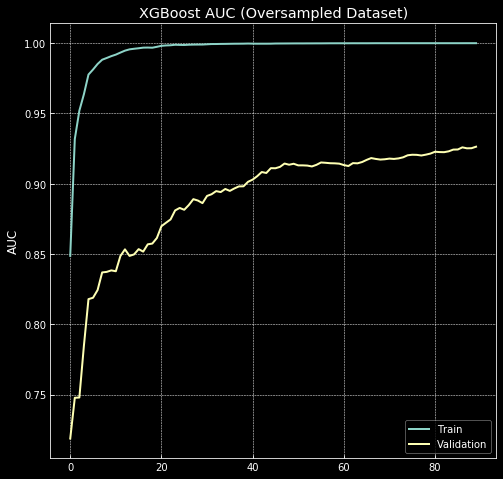

In [20]:
results = modelO.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC (Oversampled Dataset)')
plt.show()

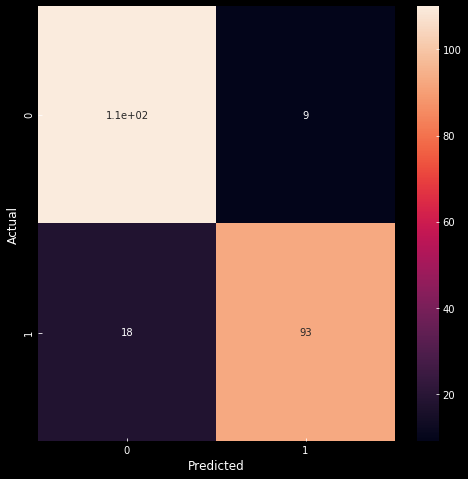

In [16]:
confusion_matrix = pd.crosstab(y_testO, predO, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

## Fine Tune Second Model

In [18]:
# Creating a sample space in which the initial randomic search should be performed
parameters = [(1e-5, 5e-1, 'log-uniform'), # learning rate
              (10, 200), # n_estimators
              (1, 11), # max_depth 
              (1, 6.), # min_child_weight 
              (0, 1), # gamma 
              (0.0, 1.), # subsample 
              (0.0, 1.),# colsample_bytree 
              (0.0, 1.),# reg_alpha          
              (0.0, 1.)]# reg_lambda

def model_tuning(params):
    # Rewrite parameters
    learning_rate = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    min_child_weight = params[3]
    gamma = params[4]
    subsample = params[5]
    colsample_bytree = params[6]
    reg_alpha = params[7]
    reg_lambda = params[8]
    print(params)

    #Model to be optimized
    modelO = xgb.XGBClassifier(learning_rate = learning_rate, 
                            n_estimators = n_estimators, 
                            max_depth = max_depth, 
                            min_child_weight = min_child_weight, 
                            gamma = gamma, 
                            subsample = subsample, 
                            colsample_bytree = colsample_bytree,
                            tree_method='gpu_hist',
                            reg_alpha = reg_alpha,
                            reg_lambda = reg_lambda,
                            seed = 2020)
    
    modelO.fit(
            X_trainU, 
            Y_trainU, 
            eval_metric="auc",  
            eval_set=[(X_trainU, Y_trainU), (X_validU, Y_validU)], 
            verbose=False,
            early_stopping_rounds = 10)
    
    pred = modelO.predict(X_testU)    
    error_mean = (1-sum(abs(Y_testU.values - pred))/len(Y_testU.values))
    
    print(error_mean)
    return -error_mean


# Minimization using a random forest with 20 random samples and 50 iterations for Bayesian optimization.
result = forest_minimize(model_tuning, parameters, random_state = 42, n_random_starts = 50, n_calls  = 100, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
[0.05532629682791238, 24, 11, 4.898455001363847, 0, 0.15601864044243655, 0.15599452033620267, 0.058083612168199475, 0.8661761457749354]
0.5111111111111111
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0550
Function value obtained: -0.5111
Current minimum: -0.5111
Iteration No: 2 started. Evaluating function at random point.
[0.006677615511747087, 161, 3, 1.1029224714790122, 1, 0.7219987722668249, 0.9385527090157504, 0.0007787658410143285, 0.9922115592912177]
0.6
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0720
Function value obtained: -0.6000
Current minimum: -0.6000
Iteration No: 3 started. Evaluating function at random point.
[0.007971262150262094, 67, 6, 1.0353315260985871, 0, 0.29122914019804197, 0.6118528947223796, 0.13949386065204186, 0.2921446485352182]
0.5777777777777777
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1250
Function value obtained

0.6888888888888889
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.0770
Function value obtained: -0.6889
Current minimum: -0.6889
Iteration No: 26 started. Evaluating function at random point.
[0.09965228389602884, 122, 8, 4.926703255569718, 1, 0.60642905965959, 0.00919705161662965, 0.10147154286603213, 0.6635017691080559]
0.48888888888888893
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 0.0600
Function value obtained: -0.4889
Current minimum: -0.6889
Iteration No: 27 started. Evaluating function at random point.
[1.0562925838885105e-05, 137, 2, 3.4280687679311335, 0, 0.6519612595026006, 0.22426930946055984, 0.712179221347536, 0.23724908749680013]
0.48888888888888893
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.1030
Function value obtained: -0.4889
Current minimum: -0.6889
Iteration No: 28 started. Evaluating function at random point.
[0.00033809863785786066, 157, 8, 4.2481644952360735, 0, 0.7209399242521294, 0.308

0.5777777777777777
Iteration No: 49 ended. Evaluation done at random point.
Time taken: 0.1460
Function value obtained: -0.5778
Current minimum: -0.7111
Iteration No: 50 started. Evaluating function at random point.
[0.04449807395755723, 161, 7, 5.653786628017825, 0, 0.23859685979034023, 0.6798447799002459, 0.7399087604473746, 0.2382361524039795]
0.6222222222222222
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 0.3030
Function value obtained: -0.6222
Current minimum: -0.7111
Iteration No: 51 started. Searching for the next optimal point.
[1.0761804786335646e-05, 63, 10, 2.369318598209447, 1, 0.7221406503499874, 0.8302352861025301, 0.9348848634303776, 0.014882927955808038]
0.5111111111111111
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.3540
Function value obtained: -0.5111
Current minimum: -0.7111
Iteration No: 52 started. Searching for the next optimal point.
[3.998439455421773e-05, 21, 4, 2.1201104627154903, 1, 0.7627039532381

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 0.3560
Function value obtained: -0.6222
Current minimum: -0.7111
Iteration No: 73 started. Searching for the next optimal point.
[1.6435020394842727e-05, 198, 9, 1.6708893986924283, 1, 0.7240698482147359, 0.32016223835107843, 0.8507868393065298, 0.10047296974344458]
0.5333333333333333
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 0.3230
Function value obtained: -0.5333
Current minimum: -0.7111
Iteration No: 74 started. Searching for the next optimal point.
[0.006853916495722184, 163, 1, 3.976202532103894, 1, 0.7140917624779142, 0.34918602161408335, 0.39311554859792797, 0.002559986150882932]
0.5111111111111111
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 0.2900
Function value obtained: -0.5111
Current minimum: -0.7111
Iteration No: 75 started. Searching for the next optimal point.
[6.50061027202793e-05, 189, 5, 1.1743464212365993, 1, 0.6843

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 0.3460
Function value obtained: -0.5556
Current minimum: -0.7111
Iteration No: 96 started. Searching for the next optimal point.
[0.3966441595886623, 191, 5, 4.567260971511523, 1, 0.7070223738536661, 0.9801956111603158, 0.78399035532211, 0.9014171017643162]
0.6444444444444444
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 0.3500
Function value obtained: -0.6444
Current minimum: -0.7111
Iteration No: 97 started. Searching for the next optimal point.
[0.33868680426786596, 169, 3, 4.4527078522649415, 1, 0.6519193178172643, 0.971378440455254, 0.8126708989863368, 0.6305038236849578]
0.6
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 0.3030
Function value obtained: -0.6000
Current minimum: -0.7111
Iteration No: 98 started. Searching for the next optimal point.
[0.0001101049824940222, 159, 4, 1.2071069753428567, 1, 0.7108381965955877, 0.129342228290

## Train Second Model

In [19]:
modelU = xgb.XGBClassifier(
    n_estimators=30,
    max_depth=3,
    learning_rate=0.00012,
    #subsample=0.9,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=0.1,
    random_state=2020,
    tree_method='gpu_hist'
)

modelU.fit(
    X_trainU, 
    Y_trainU, 
    eval_metric="auc",  #error auc
    eval_set=[(X_trainU, Y_trainU), (X_validU, Y_validU)], 
    verbose=False,
    early_stopping_rounds = 10)

predictionsU = modelU.predict(X_testU)
predU=(predictionsU>0.5).astype(int)
y_testU = Y_testU.values
print(1-sum(abs(y_testU - predU))/len(y_testU))

0.7333333333333334


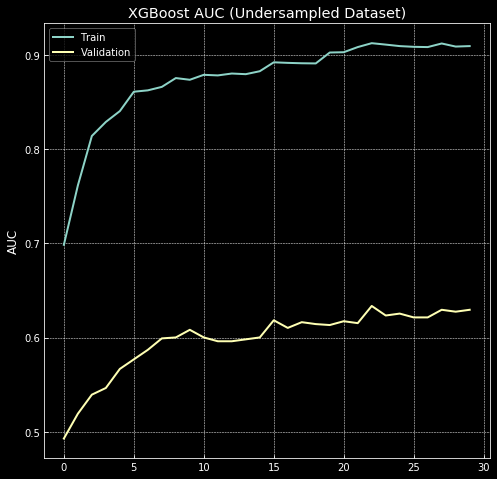

In [21]:
results = modelU.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC (Undersampled Dataset)')
plt.show()

In [696]:
X_test = X_testU
Y_test = Y_testU
proba = ((modelO.predict_proba(X_test)[:,1]*0.5 + modelU.predict_proba(X_test)[:,1]*0.5)>0.5).astype(int)
y_test = Y_test.values
print(1-sum(abs(y_test - proba))/len(y_test))

0.9777777777777777


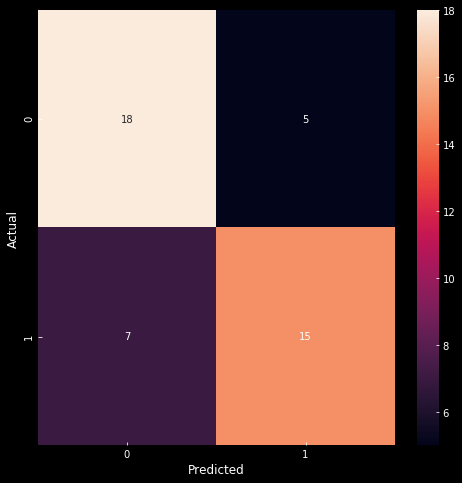

In [22]:
confusion_matrix = pd.crosstab(y_testU, predU, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [420]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

#plot_features(modelU, (10,14))

In [ ]:
import joblib
#save model
joblib.dump(modelO, 'H:/cs/modelO') 
joblib.dump(modelU, 'H:/cs/modelU') 

#load saved model
#xgb = joblib.load(filename)